In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [2]:
%pwd
# %cd /content/drive/Shared drives/ML\&HEP/Notebooks
%cd /content/drive/My\ Drive/farich-pics

/content/drive/My Drive/farich-pics


## Defining the Dataset

The [torchvision reference scripts for training object detection, instance segmentation and person keypoint detection](https://github.com/pytorch/vision/tree/v0.3.0/references/detection) allows for easily supporting adding new custom datasets.
The dataset should inherit from the standard `torch.utils.data.Dataset` class, and implement `__len__` and `__getitem__`.

The only specificity that we require is that the dataset `__getitem__` should return:

* image: a PIL Image of size (H, W)
* target: a dict containing the following fields
    * `boxes` (`FloatTensor[N, 4]`): the coordinates of the `N` bounding boxes in `[x0, y0, x1, y1]` format, ranging from `0` to `W` and `0` to `H`
    * `labels` (`Int64Tensor[N]`): the label for each bounding box
    * `image_id` (`Int64Tensor[1]`): an image identifier. It should be unique between all the images in the dataset, and is used during evaluation
    * `area` (`Tensor[N]`): The area of the bounding box. This is used during evaluation with the COCO metric, to separate the metric scores between small, medium and large boxes.
    * `iscrowd` (`UInt8Tensor[N]`): instances with `iscrowd=True` will be ignored during evaluation.
    * (optionally) `masks` (`UInt8Tensor[N, H, W]`): The segmentation masks for each one of the objects
    * (optionally) `keypoints` (`FloatTensor[N, K, 3]`): For each one of the `N` objects, it contains the `K` keypoints in `[x, y, visibility]` format, defining the object. `visibility=0` means that the keypoint is not visible. Note that for data augmentation, the notion of flipping a keypoint is dependent on the data representation, and you should probably adapt `references/detection/transforms.py` for your new keypoint representation

If your model returns the above methods, they will make it work for both training and evaluation, and will use the evaluation scripts from pycocotools.

Additionally, if you want to use aspect ratio grouping during training (so that each batch only contains images with similar aspect ratio), then it is recommended to also implement a `get_height_and_width` method, which returns the height and the width of the image. If this method is not provided, we query all elements of the dataset via `__getitem__` , which loads the image in memory and is slower than if a custom method is provided.


Теперь посмотрим на наш датасет, сохраненный в data/dataset.pkl

In [3]:
%ls /content/drive/Shared\ drives/ML\&HEP/data/

CirclesNN.pth  dataset_circles_boards.pkl  dataset.pkl


In [0]:
%pwd
# %ls ../data/dataset_circles_boards.pkl
import pickle
with open("/content/drive/Shared drives/ML&HEP/data/dataset_circles_boards.pkl", "rb") as f:
    H_res, h_res, mask_res = pickle.load(f)

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.patches import Ellipse, Circle, Rectangle

%matplotlib inline

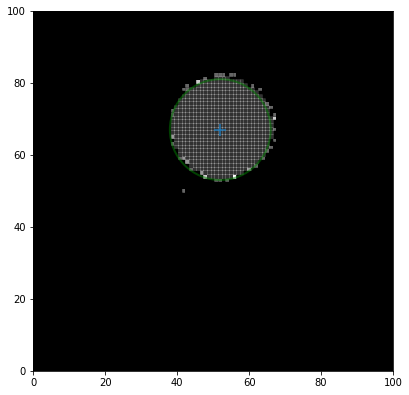

In [6]:
loc_ind = 1390
num_of_circles = 1
xv = h_res[loc_ind][num_of_circles-1][0]
yv = h_res[loc_ind][num_of_circles-1][1]
r = h_res[loc_ind][num_of_circles-1][2]

fig = plt.figure(frameon=False, figsize=(5, 5) )

H = H_res[loc_ind].toarray()
ax = plt.Axes(fig, [0., 0., 1., (H.shape[1]/H.shape[0])])
# ax.set_axis_off()
fig.add_axes(ax)

xedges = np.linspace(0, H.shape[0], H.shape[0])
yedges = np.linspace(0, H.shape[1], H.shape[1])
Xg, Yg = np.meshgrid(xedges, yedges)
e = Circle(xy=(xv, yv), radius=r, linewidth=2, fill=False, edgecolor='green', alpha=0.5)
ax.pcolormesh(Xg, Yg, H, cmap='gray')
ax.pcolormesh(Xg, Yg, mask_res[loc_ind][0].toarray(), cmap='gray', alpha=0.2)
ax.add_artist(e)
plt.scatter(xv, yv, marker='+', s=150)

In [0]:
import torch
from farichlib.Dataset import Dataset

In [0]:
data = Dataset(0.01)
data.load('/content/drive/Shared drives/ML&HEP/data/dataset_circles_boards.pkl')

In [9]:
data[0]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 {'area': tensor([948.6402]),
  'boxes': tensor([[55.6000, 32.6000, 86.4000, 63.4000]]),
  'image_id': tensor([0]),
  'labels': tensor([1]),
  'masks': tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]]])})

## Defining your model

Upload pretrained model

In [0]:
import torchvision
import math
import random
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor

def get_model(load_trained=None):
    if load_trained is None:
        num_classes = 2
        model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)
        in_features = model.roi_heads.box_predictor.cls_score.in_features
        model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
        in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
        hidden_layer = 256
        model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)
        return model
    return torch.load(load_trained)

In [0]:
model = get_model('/content/drive/Shared drives/ML&HEP/data/CirclesNN.pth')

That's it, this will make model be ready to be trained and evaluated on our custom dataset.

## Training and evaluation functions

In `references/detection/,` we have a number of helper functions to simplify training and evaluating detection models.
Here, we will use `references/detection/engine.py`, `references/detection/utils.py` and `references/detection/transforms.py`.

Let's copy those files (and their dependencies) in here so that they are available in the notebook



Let's write some helper functions for data augmentation / transformation, which leverages the functions in `refereces/detection` that we have just copied:


In [0]:
from farichlib import utils

In [0]:
def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq):
    model.train(mode=True)
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter('lr', utils.SmoothedValue(window_size=1, fmt='{value:.6f}'))
    header = 'Epoch: [{}]'.format(epoch)

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1. / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = utils.warmup_lr_scheduler(optimizer, warmup_iters, warmup_factor)

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        loss_dict = model(images, targets)

        losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print("Loss is {}, stopping training".format(loss_value))
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

### Putting everything together

We now have the dataset class, the models and the data transforms. Let's instantiate them

In [0]:
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(data)).tolist()
dataset = torch.utils.data.Subset(data, indices[:500])
dataset_test = torch.utils.data.Subset(data, indices[500:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=2, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

Now let's instantiate the model and the optimizer

In [0]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

And now let's train the model for 10 epochs, evaluating at the end of every epoch.

In [16]:
# let's train it for 10 epochs
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset
    #evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/250]  eta: 0:06:18  lr: 0.000025  loss: 0.1685 (0.1685)  loss_classifier: 0.0428 (0.0428)  loss_box_reg: 0.0099 (0.0099)  loss_mask: 0.1106 (0.1106)  loss_objectness: 0.0045 (0.0045)  loss_rpn_box_reg: 0.0008 (0.0008)  time: 1.5129  data: 0.2043  max mem: 1636
Epoch: [0]  [ 10/250]  eta: 0:01:33  lr: 0.000226  loss: 0.1830 (0.2480)  loss_classifier: 0.0419 (0.0488)  loss_box_reg: 0.0096 (0.0141)  loss_mask: 0.1317 (0.1778)  loss_objectness: 0.0044 (0.0056)  loss_rpn_box_reg: 0.0011 (0.0016)  time: 0.3911  data: 0.0249  max mem: 1916
Epoch: [0]  [ 20/250]  eta: 0:01:17  lr: 0.000426  loss: 0.1329 (0.2018)  loss_classifier: 0.0312 (0.0367)  loss_box_reg: 0.0062 (0.0102)  loss_mask: 0.0939 (0.1428)  loss_objectness: 0.0020 (0.0102)  loss_rpn_box_reg: 0.0009 (0.0018)  time: 0.2783  data: 0.0065  max mem: 1916
Epoch: [0]  [ 30/250]  eta: 0:01:09  lr: 0.000627  loss: 0.1125 (0.1791)  loss_classifier: 0.0173 (0.0318)  loss_box_reg: 0.0055 (0.0095)  loss_mask: 0.0924 (0.1289) 

Now that training has finished, let's have a look at what it actually predicts in a test image

Printing the prediction shows that we have a list of dictionaries. Each element of the list corresponds to a different image. As we have a single image, there is a single dictionary in the list.
The dictionary contains the predictions for the image we passed. In this case, we can see that it contains `boxes`, `labels`, `masks` and `scores` as fields.

Let's inspect the image and the predicted segmentation masks.

For that, we need to convert the image, which has been rescaled to 0-1 and had the channels flipped so that we have it in `[C, H, W]` format.

In [0]:
def show(index, model, threshold=0.9):
    # pick one image from the test set
    img, bbox = dataset_test[ind]
    # put the model in evaluation mode
    model.eval()
    with torch.no_grad():
        prediction = model([img.to(device)])

    f, (ax2, ax) = plt.subplots(1, 2, sharey=True, figsize=(15, 15))

    H = img.squeeze(0).numpy()

    ax.set_aspect(H.shape[1]/H.shape[0])
    ax2.set_aspect(H.shape[1]/H.shape[0])

    ax.title.set_text('NN response')
    ax2.title.set_text('Real data')

    masks = prediction[0]['masks'][prediction[0]['scores']>threshold]
    bboxes = prediction[0]['boxes'][prediction[0]['scores']>threshold]
    scores = prediction[0]['scores'][prediction[0]['scores']>threshold]

    mask_expected = bbox['masks'][0].numpy()

    xedges = np.linspace(0, H.shape[0], H.shape[0])
    yedges = np.linspace(0, H.shape[1], H.shape[1])
    Xg, Yg = np.meshgrid(xedges, yedges)

    for a in (ax, ax2):
      a.title.set_size(20)
      a.set_axis_off()
      a.pcolormesh(Xg, Yg, H, cmap='gray')

    for mask,bbox,score in zip(masks,bboxes,scores):
        m = mask[0].cpu().numpy()
        b = bbox.cpu().numpy()
        ax.pcolormesh(Xg, Yg, m, cmap='gnuplot2', alpha=0.3)
        ax.add_patch(Rectangle((b[0], b[1]), b[2]-b[0], b[3]-b[1], ec='r', fc='none'))
        ax.annotate(f'Score: {score.item():.2f}', (b[0], b[3]+1), color='r', size=16)

    ax2.pcolormesh(Xg, Yg, mask_expected, cmap='gnuplot', alpha=0.1)

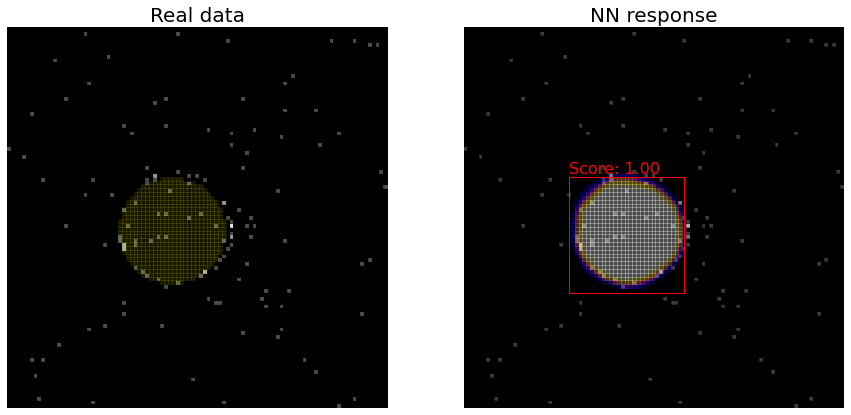

In [26]:
ind = random.randint(0, len(dataset_test)-1)
show(ind, model, 0.5)

##Save entire model ([guide](https://pytorch.org/tutorials/beginner/saving_loading_models.html))

In [0]:
torch.save(model, '../data/CirclesNN_310320.pth')